# Tutorial 3: Detecting plankton from video.

This tutorial demonstrates how to use LodeSTAR model to detect plankton from video. [LodeSTAR](https://www.nature.com/articles/s41467-022-35004-y) is a deep learning framework which uses self-supervised learning to train a fully convolutional neural network for detecting plankton from microscopy video frames. The training is performed with the help of only a *single* plankton crop from any video frame of users choice.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/softmatterlab/Deep-learning-in-plankton-ecology/blob/main/detection-tutorials/3-detection_plankton3.ipynb)

This tutorial demonstrates how to train LodeSTAR for detecting plankton positions from video frames. It covers information on:

* Loading any experimental video containing plankton
* Selecting plankton crop(s) from any video frame
* Defining and training LodeSTAR model
* Testing the model on the video frames

Run the following cell to install the required python packages to run this tutorial.

In [ ]:
!pip install deeptrack
!pip install tqdm

In [1]:
%matplotlib inline

## 1. Setup
Imports the required python packages needed to run this tutorial.

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
import datetime
import imageio
import deeptrack as dt

## 2. Load the video
### 2.1. Define a function to load the video
In the following cell, we write a function to load the microscopy video. The function takes the path to the video file as input and returns the video as a numpy array.

In [3]:
def load_video(path, start=0, end=None):
    video= cv2.VideoCapture(path)
    frames=[]
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    if end:
        end = min(end, total_frames)
    else:
        end = total_frames
    for i in tqdm(range(start, end, 1), desc="loading frames"):
        video.set(1, i)
        ret, frame=video.read()
        gray_frame = frame#[:,:,0]
        frames.append(gray_frame)
    return np.array(frames)

### 2.2. Load the video
The video for this tutorial is available under the `data/plankton-videos` directory under the name `plankton_video3.mp4`. We use the function defined above to load the video. Adjust the path to the video file if you are using a different video.

In [4]:
path = "../original-videos/Plankton3.mp4"
frames = load_video(path, end=200)

loading frames: 100%|██████████| 200/200 [00:29<00:00,  6.88it/s]


Display the fist frame of the video to check if the video is loaded correctly.

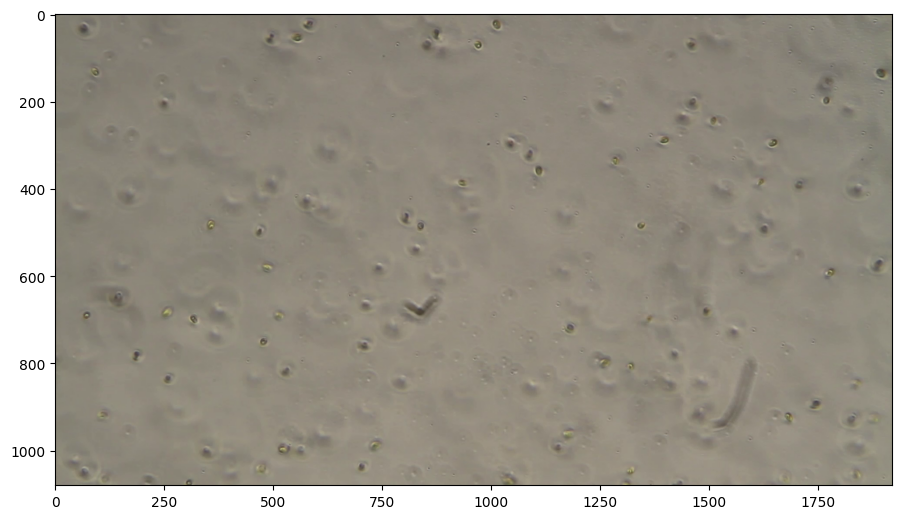

In [5]:
# %matplotlib tk
# To display image in original colors
dpi = 100
frame = frames[0]
plt.figure(figsize=(frame.shape[0]/dpi, frame.shape[1]/dpi), dpi=dpi)
plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
plt.show()

## 3. Select plankton crop(s) from the video frame
### 3.1. Define plankton positions
Define approximate plankton positions in the above video frame in the from of coordinates (x, y).

In [6]:
plankton_positions = [
    [1344, 481],
    [931, 382],
    [355, 479],
    [1644, 290],
    [250, 206]
]

### 3.2. Crop the plankton
Crop the plankton positions by using the coordinates defined above. The cropped plankton images are stored in a list.
The crop size can be adjusted by controlling the `crop_width` parameter. The default value is 150 pixels. This will generate a 150x150 pixel crop around the plankton position.

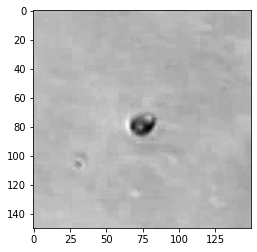

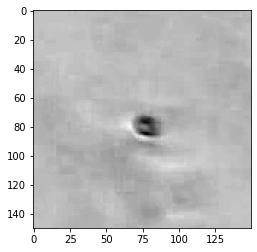

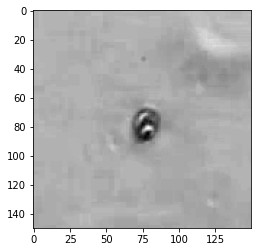

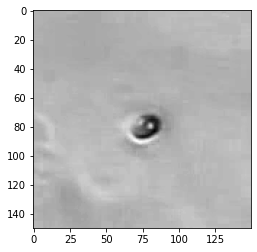

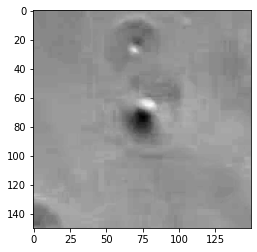

In [7]:
crop_width = 150
crops = []
for pos in plankton_positions:
    crop = frame[int(pos[1] - crop_width/2) :int(pos[1] + crop_width/2), int(pos[0] - crop_width/2) : int(pos[0] + crop_width/2)][:,:,0]
    crops.append(crop)
    plt.imshow(crop, cmap="gray")
    plt.show()
crops = np.expand_dims(crops, axis=-1)

### 3.3. Select a random crop
Select a random crop from the list of cropped plankton images. This will be used for training the LodeSTAR model. Having multiple good crops will give us a choice to select the best crop for training. In this case, we have randomly select a crop from the list of good crops we have generated above.

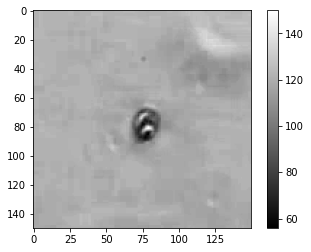

In [8]:
import random
# random.seed(20)
crop = random.choice(crops)
plt.imshow(crop, cmap="gray")
plt.colorbar()

In [9]:
random_crop = dt.Value(lambda: random.choice(crops))

Define a downsampling parameter to control the size of the cropped plankton image. The default value is 2. This will downsample the cropped plankton image by a factor of 2. This will generate a 75x75 pixel crop around the plankton position. By having this we need not generate multiple crops for different crop sizes.

In [10]:
downsample = 2

## 4. Train the LodeSTAR model
In the following code, we define and train the LodeSTAR model. Set the parameter, ``TRAIN`` to `True` to train the model from scratch. If you want to use the pre-trained model, set the parameter to `False`.

The pre-trained models are located in directory `data/pre-trained-models`. The pre-trained model is named as `lodestar-model-plankton3.h5`.

In [11]:
TRAIN = False

if TRAIN:
    model = dt.models.LodeSTAR(input_shape=(None, None, 1))
    train_set =   (
        dt.Value(random_crop)
        >> dt.AveragePooling(ksize=(downsample, downsample, 1))
        # >> dt.Affine(rotate=lambda: np.random.rand()*np.pi*2, scale=lambda:np.random.uniform(0.95, 1.05, 2))
        # >> dt.Add(lambda: np.random.randn() * 0.2)
        # >> dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.01))  
        # >> dt.Multiply(lambda: np.random.uniform(0.3, 1.6))
    )

    model.fit(
        train_set,
        epochs=20,
        batch_size=8,
        verbose=1
    )

    model.model.model.save_weights("lodestar-model-plankton3.h5")

else:
    model = dt.models.LodeSTAR(input_shape=(None, None, 1))
    model.model.model.load_weights("../data/pre-trained-models/lodestar-model-plankton3.h5")

2022-10-18 17:46:24.432846: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 17:46:24.443912: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-18 17:46:24.447395: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: AMD Radeon Pro 5300M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB

Generating 172 / 160 samples before starting training
Epoch 1/20


2022-10-18 17:46:32.572068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


172/172 [==============================] - 9s 35ms/step - total_loss: 4.7843 - consistency_loss: 2.8035
Epoch 2/20
172/172 [==============================] - 6s 36ms/step - total_loss: 2.3145 - consistency_loss: 1.2797
Epoch 3/20
172/172 [==============================] - 6s 37ms/step - total_loss: 4.2428 - consistency_loss: 2.6707
Epoch 4/20
172/172 [==============================] - 6s 35ms/step - total_loss: 3.9652 - consistency_loss: 2.4063
Epoch 5/20
172/172 [==============================] - 6s 38ms/step - total_loss: 4.4897 - consistency_loss: 2.2632
Epoch 6/20
172/172 [==============================] - 7s 38ms/step - total_loss: 4.4036 - consistency_loss: 2.7374
Epoch 7/20
172/172 [==============================] - 6s 36ms/step - total_loss: 3.9490 - consistency_loss: 2.3725
Epoch 8/20
172/172 [==============================] - 7s 38ms/step - total_loss: 1.9927 - consistency_loss: 1.0602
Epoch 9/20
172/172 [==============================] - 7s 39ms/step - total_loss: 0.2605 - c

## 5. Check the model performance
The following few cells of code are not important. You can directly jump to step 6.

This next few lines of code is just to cross-check whether the trained model is able to process a given crop or not. If the model is able to process the crop, you will be able to see a shadow of the plankton like the shown in the second image plotted below.

In [12]:
crop2 = np.expand_dims(crop, axis=0)

In [13]:
p, w = model.predict(crop2)

1/1 [==============================] - 0s 294ms/step


2022-10-18 17:48:55.270118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


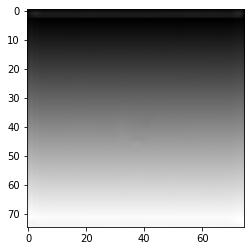

In [14]:
plt.imshow(p[0,:,:,0], cmap="gray")

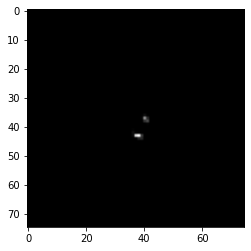

In [15]:
plt.imshow(w[0,:,:,0], cmap="gray")

## 6. Test the model of a video frame
### 6.1. Predict the plankton position
Here we test the model on a video frame. We use the same video frame we used for training the model. The model is able to detect the plankton position in the video frame.

Adjust the `starting_frame` and `ending_frame` parameters to select the range of video frames you want to test the model on. By default, the model is tested on the full video. This will take some time to process.

In [18]:
#May need to tune these to get optimal performance!
alpha = 1
cutoff = 0.1

starting_frame = 0
ending_frame = len(frames)

frames2 = np.expand_dims(frames[:,:,:,0], axis=-1)
detections = model.predict_and_detect(frames2[starting_frame:ending_frame, ::downsample, ::downsample, :1], alpha=alpha, beta=1-alpha, cutoff=cutoff, mode="constant")


7/7 [==============================] - 34s 4s/step


### 6.2. Plot the results
Here we overlay the predicted plankton position on the video frame. The plankton position is plotted as a red circle. As you can see, the model is able to detect the plankton position in the video frame. The above process can be repeated for any microscopy video.

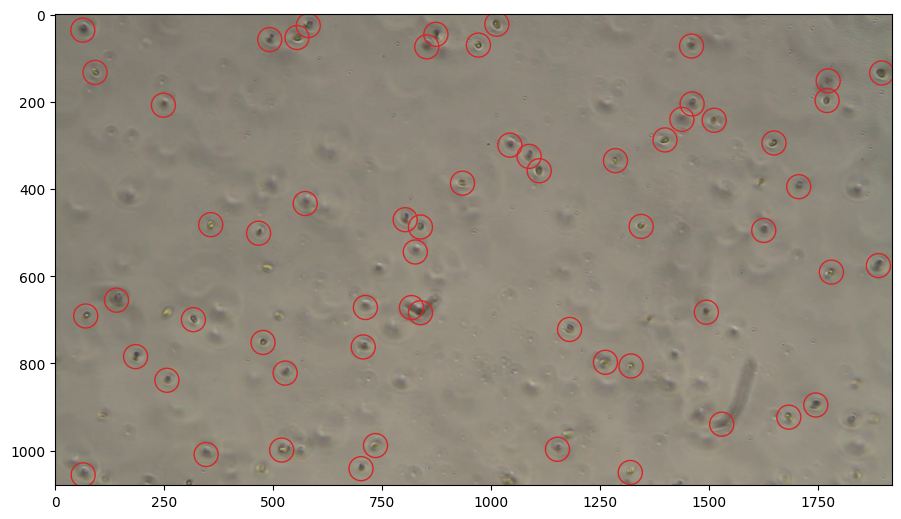

In [19]:
frame_no = 0
plt.figure(figsize=(frame.shape[0]/dpi, frame.shape[1]/dpi), dpi=dpi)
plt.imshow(cv2.cvtColor(frames[frame_no], cv2.COLOR_BGR2RGB))
plt.scatter(detections[frame_no][:,1] * downsample , detections[frame_no][:,0] * downsample, s = 300, facecolors="none", edgecolors="tab:red")

### 6.3. Save the results
The following code will save the results as a video file. Please adjust the path by changing the `path` parameter accordingly.

In [20]:
_dpi = 200
images = []
path = "../detection-videos/Detection-Plankton3.mp4"

for i in range(len(frames)):
    fig, ax = plt.subplots(
        figsize=(frame.shape[1]/ _dpi, frame.shape[0] / _dpi), dpi=_dpi, frameon=False
    )
    ax.set_axis_off()
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
    plt.margins(0, 0)
    plt.imshow(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB), origin="upper")
    plt.scatter(
        detections[i][:, 1] * downsample,
        detections[i][:, 0] * downsample,
        s=300,
        facecolors="none",
        edgecolors="tab:red",
    )
    fig.canvas.draw()
    arr = np.array(fig.canvas.renderer.buffer_rgba())
    images.append(arr)

    fig.clear()
    plt.close(fig)
    plt.show()

imageio.mimsave(path, images, fps=30)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1920, 1080) to (1920, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
